In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)

In [3]:
params.shape

(32, 3, 4)

In [4]:
def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X)[:,0] + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [6]:
xs

array([[[ 0.19346423, -0.49674494,  1.03272322],
        [ 0.75089704, -0.24004044,  1.56023568],
        [ 1.32750344, -0.11221079,  1.71005292],
        [ 1.52194586, -0.21827614,  1.65352565],
        [ 1.59104575, -0.36965128,  1.71710531],
        [ 1.94791322, -0.38744022,  1.88844369],
        [ 2.00793466, -0.50160722,  2.08154117],
        [ 2.16763723, -0.23440914,  2.53786771],
        [ 2.5673579 , -0.02512258,  2.26939423],
        [ 2.32300895, -0.17351812,  1.89459183],
        [ 1.91274935, -0.4183005 ,  1.98138751],
        [ 2.11211229, -0.54368057,  2.17311137],
        [ 2.2869644 , -0.4955708 ,  2.58477752],
        [ 2.76532993, -0.36920278,  2.7437916 ],
        [ 2.88744677, -0.40642631,  2.69340905],
        [ 2.91296897, -0.61181592,  2.76246208],
        [ 3.15824728, -0.70285377,  2.91540517],
        [ 3.39448326, -0.72092846,  3.2602625 ],
        [ 3.75839297, -0.59519568,  3.5311124 ],
        [ 3.91858443, -0.51728211,  3.68425203],
        [ 3.97623264

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=None):
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([ResFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(4)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_33:0' shape=() dtype=float64>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 32, 3)

In [17]:
logl

<tf.Tensor 'add_126:0' shape=() dtype=float64>

In [18]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [19]:
ent

<tf.Tensor 'Sum_33:0' shape=() dtype=float64>

In [20]:
loss = -logl - prior + ent
loss /= n*dim[0]*dim[1]

In [21]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
prior.eval(), ent.eval(), logl.eval()

(892.6065210959315, 1623.158627715387, -157251.62501676942)

In [25]:
loss.eval()

298.9519353140313

In [35]:
for _ in range(500):
    for _ in range(200):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)

2.887851859968587
2.8704716341213987
2.620926698381273
4.846664335420702
2.0522718545555865
1.9470561808912314
2.7187537671890856
2.206639948795186
1.5581798937075029
1.8986520555180144
2.665936027251863
1.9057121296211157
1.6336212659730176
2.0972879911431095
2.3322678607356884
1.6855541192842736
2.722354730153196
2.6421200678295


KeyboardInterrupt: 

In [27]:
out = tf.reshape(outputs, [n, 3, 4])

In [36]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [37]:
samples.shape

(1000, 32, 3, 4)

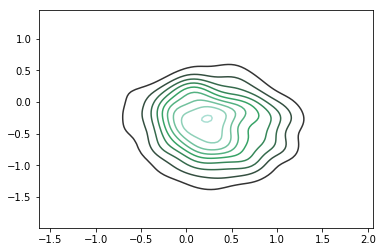

In [41]:
sns.kdeplot(samples[:,18,1,1], samples[:,18,0,1])
plt.show()

In [39]:
params[18]

array([[ 0.26256903, -0.6518162 ,  0.74696963, -0.15384126],
       [-0.3732683 ,  0.49052328,  0.44550811, -0.37385512],
       [ 0.05862716, -1.18001719,  0.62563793,  0.5192165 ]])

In [40]:
np.mean(samples[:,18], axis=0)

array([[ 0.42281045, -0.36397376,  0.4974505 ,  0.36515963],
       [-0.08557398,  0.27559012, -0.0145765 , -0.0736605 ],
       [ 0.2825587 , -0.66559299,  0.4854842 ,  0.49468611]])

In [51]:
params[0] - params[-1]

array([[-0.03363443,  0.01594778, -0.05966114, -0.03184394],
       [ 0.01225283, -0.06333269,  0.01810212,  0.05804125],
       [-0.0916567 ,  0.03942744, -0.0750497 , -0.04911167]])